In [10]:
import boto3
import sagemaker
import csv


sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_rows', None)

In [12]:
!aws s3 cp --recursive s3://aurelia-resort-data/ ./data/

download: s3://aurelia-resort-data/airbnb/neighbourhoods/neighbourhoods.csv to data/airbnb/neighbourhoods/neighbourhoods.csv
download: s3://aurelia-resort-data/income/dsp_income.csv to data/income/dsp_income.csv
download: s3://aurelia-resort-data/airbnb/calendar/calendar.csv.gz to data/airbnb/calendar/calendar.csv.gz
download: s3://aurelia-resort-data/Hotel bookings/hotel_bookings to data/Hotel bookings/hotel_bookings
download: s3://aurelia-resort-data/Hotel bookings/hotel_bookings.csv to data/Hotel bookings/hotel_bookings.csv
download: s3://aurelia-resort-data/airbnb/listings/listings.csv to data/airbnb/listings/listings.csv
download: s3://aurelia-resort-data/travel/airline_2016.csv to data/travel/airline_2016.csv
download: s3://aurelia-resort-data/travel/airline_2017.csv to data/travel/airline_2017.csv
download: s3://aurelia-resort-data/travel/airline_2018.csv to data/travel/airline_2018.csv
download: s3://aurelia-resort-data/travel/airline_2022.csv to data/travel/airline_2022.csv
do

#### Ingesting Data via Pandas

In [13]:
booking = pd.read_csv("./data/Hotel bookings/hotel_bookings.csv")

income =  pd.read_csv("./data/Hotel bookings/hotel_bookings.csv")

# EDA

### Data Shapes

In [14]:
income.shape

(119390, 32)

In [15]:
booking.shape

(119390, 32)

### Data Previews

In [16]:
income.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [17]:
booking.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Summary Statistics

In [18]:
income.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [19]:
booking.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


### data types and info

In [20]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [21]:
booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Null Values

In [22]:
income.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [23]:
booking.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

#### Drop Company 90 % of data is missing. 

In [24]:
booking.drop('company', inplace=True, axis=1)

In [25]:
booking.drop('arrival_date_week_number', inplace=True, axis=1)

In [26]:
booking.drop('country', inplace=True, axis=1)

In [27]:
booking.shape

(119390, 29)

#### Data imputation and manipulation

Median will be used to fill na's for children and agent. While country will be filled using Mode. 

In [28]:
booking['children'] = booking['children'].fillna(booking['children'].median())

In [29]:
booking['agent'] = booking['agent'].fillna(booking['agent'].median())

In [30]:
booking.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status          

In [31]:
booking['arrival_date_year'] = booking['arrival_date_year'].apply(lambda x: str(x))

In [32]:
booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  object 
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_day_of_month       119390 non-null  int64  
 6   stays_in_weekend_nights         119390 non-null  int64  
 7   stays_in_week_nights            119390 non-null  int64  
 8   adults                          119390 non-null  int64  
 9   children                        119390 non-null  float64
 10  babies                          119390 non-null  int64  
 11  meal                            119390 non-null  object 
 12  market_segment  

In [33]:
booking.drop('reservation_status', inplace=True, axis=1)

In [34]:
booking['reservation_status_date']= pd.to_datetime(booking['reservation_status_date'],format='%Y-%m-%d')

In [35]:
booking.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,342,2015,July,1,0,0,2,0.0,...,C,3,No Deposit,14.0,0,Transient,0.0,0,0,2015-07-01
1,Resort Hotel,0,737,2015,July,1,0,0,2,0.0,...,C,4,No Deposit,14.0,0,Transient,0.0,0,0,2015-07-01
2,Resort Hotel,0,7,2015,July,1,0,1,1,0.0,...,C,0,No Deposit,14.0,0,Transient,75.0,0,0,2015-07-02
3,Resort Hotel,0,13,2015,July,1,0,1,1,0.0,...,A,0,No Deposit,304.0,0,Transient,75.0,0,0,2015-07-02
4,Resort Hotel,0,14,2015,July,1,0,2,2,0.0,...,A,0,No Deposit,240.0,0,Transient,98.0,0,1,2015-07-03


#### Convert reservation status date to datetime format

In [36]:
booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  object        
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_day_of_month       119390 non-null  int64         
 6   stays_in_weekend_nights         119390 non-null  int64         
 7   stays_in_week_nights            119390 non-null  int64         
 8   adults                          119390 non-null  int64         
 9   children                        119390 non-null  float64       
 10  babies                          119390 non-null  int64  

#### Separate date into year, date, month for new features

In [37]:
booking['reservation_year']= booking['reservation_status_date'].dt.year
booking['reservation_month']=booking['reservation_status_date'].dt.month
booking['reservation_day']= booking['reservation_status_date'].dt.day

In [38]:
booking.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,reservation_year,reservation_month,reservation_day
0,Resort Hotel,0,342,2015,July,1,0,0,2,0.0,...,14.0,0,Transient,0.0,0,0,2015-07-01,2015,7,1
1,Resort Hotel,0,737,2015,July,1,0,0,2,0.0,...,14.0,0,Transient,0.0,0,0,2015-07-01,2015,7,1
2,Resort Hotel,0,7,2015,July,1,0,1,1,0.0,...,14.0,0,Transient,75.0,0,0,2015-07-02,2015,7,2
3,Resort Hotel,0,13,2015,July,1,0,1,1,0.0,...,304.0,0,Transient,75.0,0,0,2015-07-02,2015,7,2
4,Resort Hotel,0,14,2015,July,1,0,2,2,0.0,...,240.0,0,Transient,98.0,0,1,2015-07-03,2015,7,3


In [39]:
income['date']= pd.to_datetime(income['date'],format='%Y-%m-%d')
income.info()

KeyError: 'date'

In [40]:
income['year']= income['date'].dt.year
income['month']=income['date'].dt.month
income['day']= income['date'].dt.day

KeyError: 'date'

In [41]:
income.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


####  Data Cleaning


In [42]:
booking_copy = booking.copy()

In [43]:
booking_copy['is_canceled'] = booking_copy.is_canceled.replace([1,0],["Cancelled","Not Cancelled"])
booking_cancelled = booking_copy['is_canceled']

Text(0.5, 0, 'Bookings Cancelled')

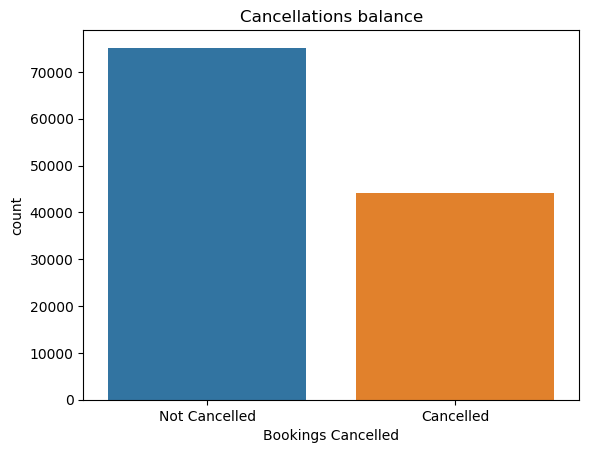

In [44]:
sns.countplot(booking_cancelled).set_title("Cancellations balance")
plt.xlabel("Bookings Cancelled")


In [45]:
booking['hotel'] = booking.hotel.replace(['Resort Hotel', 'City Hotel'],[1, 0])


In [46]:
booking.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,reservation_year,reservation_month,reservation_day
0,1,0,342,2015,July,1,0,0,2,0.0,...,14.0,0,Transient,0.0,0,0,2015-07-01,2015,7,1
1,1,0,737,2015,July,1,0,0,2,0.0,...,14.0,0,Transient,0.0,0,0,2015-07-01,2015,7,1
2,1,0,7,2015,July,1,0,1,1,0.0,...,14.0,0,Transient,75.0,0,0,2015-07-02,2015,7,2
3,1,0,13,2015,July,1,0,1,1,0.0,...,304.0,0,Transient,75.0,0,0,2015-07-02,2015,7,2
4,1,0,14,2015,July,1,0,2,2,0.0,...,240.0,0,Transient,98.0,0,1,2015-07-03,2015,7,3


In [47]:
import calendar
print(dict((month, index) for index, month in enumerate(calendar.month_abbr) if month))

{'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}


In [48]:
booking['arrival_date_month'] = pd.to_datetime(booking.arrival_date_month, format='%B').dt.month.astype(str) 

In [49]:
booking.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,reservation_year,reservation_month,reservation_day
0,1,0,342,2015,7,1,0,0,2,0.0,...,14.0,0,Transient,0.0,0,0,2015-07-01,2015,7,1
1,1,0,737,2015,7,1,0,0,2,0.0,...,14.0,0,Transient,0.0,0,0,2015-07-01,2015,7,1
2,1,0,7,2015,7,1,0,1,1,0.0,...,14.0,0,Transient,75.0,0,0,2015-07-02,2015,7,2
3,1,0,13,2015,7,1,0,1,1,0.0,...,304.0,0,Transient,75.0,0,0,2015-07-02,2015,7,2
4,1,0,14,2015,7,1,0,2,2,0.0,...,240.0,0,Transient,98.0,0,1,2015-07-03,2015,7,3


In [50]:
booking.describe()

,hotel,is_canceled,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_year,reservation_month,reservation_day
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.335539,0.370416,104.011416,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,...,0.137097,0.221124,76.744392,2.321149,101.831122,0.062518,0.571363,2016.093743,6.334123,15.666639
std,0.472181,0.482918,106.863097,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,...,1.497437,0.652306,105.904658,17.594721,50.535790,0.245291,0.792798,0.715306,3.346352,8.778432
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,-6.380000,0.000000,0.000000,2014.000000,1.000000,1.000000
25%,0.000000,0.000000,18.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,9.000000,0.000000,69.290000,0.000000,0.000000,2016.000000,3.000000,8.000000
50%,0.000000,0.000000,69.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,14.000000,0.000000,94.575000,0.000000,0.000000,2016.000000,6.000000,16.000000
75%,1.000000,1.000000,160.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,152.000000,0.000000,126.000000,0.000000,1.000000,2017.000000,9.000000,23.000000
max,1.000000,1.000000,737.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,...,72.000000,21.000000,535.000000,391.000000,5400.000000,8.000000,5.000000,2017.000000,12.000000,31.000000


In [51]:
booking.dtypes

hotel                                      int64
is_canceled                                int64
lead_time                                  int64
arrival_date_year                         object
arrival_date_month                        object
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                      object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type                        object
booking_changes                            int64
deposit_type        

In [52]:
booking['meal'].value_counts()

BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64

In [53]:
booking['market_segment'].value_counts()

Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: market_segment, dtype: int64

In [54]:
booking['distribution_channel'].value_counts()

TA/TO        97870
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: distribution_channel, dtype: int64

In [55]:
booking['reserved_room_type'].value_counts()

A    85994
D    19201
E     6535
F     2897
G     2094
B     1118
C      932
H      601
P       12
L        6
Name: reserved_room_type, dtype: int64

In [56]:
booking['assigned_room_type'].value_counts()

A    74053
D    25322
E     7806
F     3751
G     2553
C     2375
B     2163
H      712
I      363
K      279
P       12
L        1
Name: assigned_room_type, dtype: int64

In [57]:
booking['deposit_type'].value_counts()

No Deposit    104641
Non Refund     14587
Refundable       162
Name: deposit_type, dtype: int64

In [58]:
booking['customer_type'].value_counts()

Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: customer_type, dtype: int64

In [59]:
booking_with_dummies = pd.get_dummies(booking, columns=['customer_type','deposit_type','assigned_room_type', 'reserved_room_type', 'distribution_channel', 'market_segment','meal'])

In [60]:
booking_with_dummies['arrival_date_year'] = booking_with_dummies.arrival_date_year.astype('int64') 

In [61]:
booking_with_dummies['arrival_date_month'] = booking_with_dummies.arrival_date_month.astype('int64') 

In [62]:
#booking_with_dummies.drop('reservation_status_date', inplace=True, axis=1)


In [63]:
pd.options.display.max_columns = booking_with_dummies.shape[1]

In [64]:
booking_with_dummies.describe()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_year,reservation_month,reservation_day,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.00000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.335539,0.370416,104.011416,2016.156554,6.552483,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,76.744392,2.321149,101.831122,0.062518,0.571363,2016.093743,6.334123,15.666639,0.03414,0.004833,0.750591,0.210436,0.876464,0.122179,0.001357,0.620261,0.018117,0.019893,0.212095,0.065382,0.031418,0.021384,0.005964,0.003040,0.002337,0.000008,0.000101,0.720278,0.009364,0.007806,0.160826,0.054737,0.024265,0.017539,0.005034,0.000050,0.000101,0.055926,0.122665,0.001617,0.819750,0.000042,0.001985,0.006223,0.044350,0.105587,0.165935,0.202856,0.473046,0.000017,0.773180,0.006684,0.121141,0.089203,0.009791
std,0.472181,0.482918,106.863097,0.707476,3.090619,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,105.904658,17.594721,50.535790,0.245291,0.792798,0.715306,3.346352,8.778432,0.18159,0.069351,0.432673,0.407620,0.329053,0.327494,0.036811,0.485324,0.133375,0.139632,0.408793,0.247200,0.174445,0.144660,0.076994,0.055057,0.048285,0.002894,0.010025,0.448864,0.096315,0.088008,0.367372,0.227466,0.153871,0.131269,0.070772,0.007089,0.010025,0.229780,0.328054,0.040174,0.384397,0.006471,0.044510,0.078642,0.205873,0.307309,0.372024,0.402128,0.499275,0.004093,0.418777,0.081482,0.326292,0.285038,0.098466
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-6.380000,0.000000,0.000000,2014.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

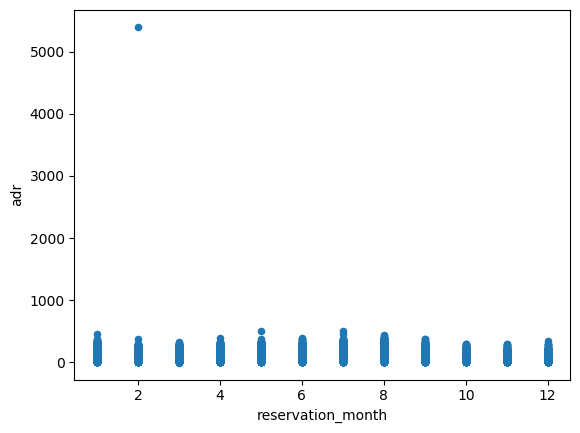

In [65]:
booking_with_dummies.plot(kind = 'scatter', x = 'reservation_month', y = 'adr')

In [66]:
booking_scaled = booking_with_dummies.copy()
column = 'adr'
booking_scaled[column] = booking_scaled[column] /booking_scaled[column].abs().max()
booking_scaled.describe()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_year,reservation_month,reservation_day,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.00000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.335539,0.370416,104.011416,2016.156554,6.552483,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,76.744392,2.321149,0.018858,0.062518,0.571363,2016.093743,6.334123,15.666639,0.03414,0.004833,0.750591,0.210436,0.876464,0.122179,0.001357,0.620261,0.018117,0.019893,0.212095,0.065382,0.031418,0.021384,0.005964,0.003040,0.002337,0.000008,0.000101,0.720278,0.009364,0.007806,0.160826,0.054737,0.024265,0.017539,0.005034,0.000050,0.000101,0.055926,0.122665,0.001617,0.819750,0.000042,0.001985,0.006223,0.044350,0.105587,0.165935,0.202856,0.473046,0.000017,0.773180,0.006684,0.121141,0.089203,0.009791
std,0.472181,0.482918,106.863097,0.707476,3.090619,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,105.904658,17.594721,0.009358,0.245291,0.792798,0.715306,3.346352,8.778432,0.18159,0.069351,0.432673,0.407620,0.329053,0.327494,0.036811,0.485324,0.133375,0.139632,0.408793,0.247200,0.174445,0.144660,0.076994,0.055057,0.048285,0.002894,0.010025,0.448864,0.096315,0.088008,0.367372,0.227466,0.153871,0.131269,0.070772,0.007089,0.010025,0.229780,0.328054,0.040174,0.384397,0.006471,0.044510,0.078642,0.205873,0.307309,0.372024,0.402128,0.499275,0.004093,0.418777,0.081482,0.326292,0.285038,0.098466
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.001181,0.000000,0.000000,2014.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

#### correlation heatmap

In [67]:
print(booking_scaled.corr())

                                   hotel  is_canceled  lead_time  \
hotel                           1.000000    -0.136531  -0.075381   
is_canceled                    -0.136531     1.000000   0.293123   
lead_time                      -0.075381     0.293123   1.000000   
arrival_date_year              -0.035267     0.016660   0.040142   
arrival_date_month             -0.001817     0.011022   0.131424   
arrival_date_day_of_month       0.001862    -0.006130   0.002268   
stays_in_weekend_nights         0.186596    -0.001791   0.085671   
stays_in_week_nights            0.234020     0.024765   0.165799   
adults                          0.013183     0.060017   0.119519   
children                        0.044210     0.005036  -0.037613   
babies                          0.043434    -0.032491  -0.020915   
is_repeated_guest               0.050421    -0.084793  -0.124410   
previous_cancellations          0.012292     0.110133   0.086042   
previous_bookings_not_canceled  0.004441    -0.0

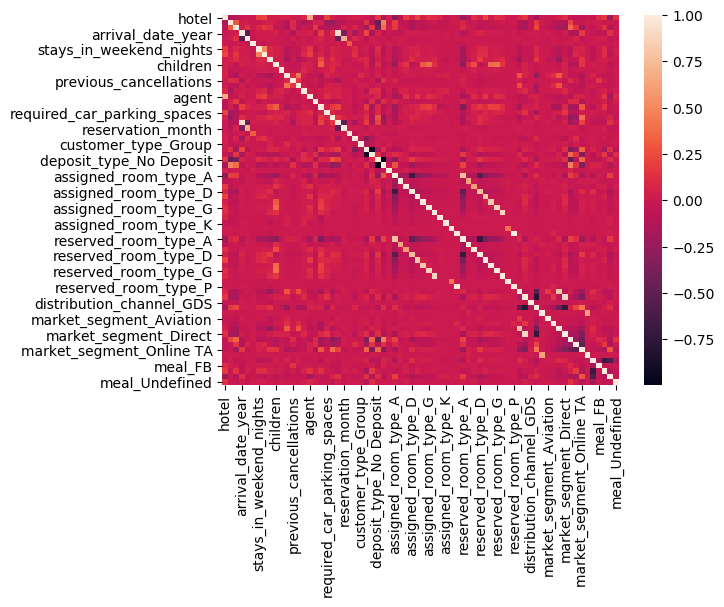

In [68]:
dataplot=sns.heatmap(booking_scaled.corr())
plt.show()

In [69]:
booking_scaled['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [70]:
class_count_0, class_count_1 = booking_scaled['is_canceled'].value_counts()

In [71]:
class_0 = booking_scaled[booking_scaled['is_canceled'] == 0]
class_1 = booking_scaled[booking_scaled['is_canceled'] == 1]

print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (75166, 71)
class 1: (44224, 71)


In [72]:
class_1_oversamp = class_1.sample(class_count_0, replace=True)

test_oversamp = pd.concat([class_1_oversamp,class_0], axis=0)


total class of 1 and 0: 1    75166
0    75166
Name: is_canceled, dtype: int64


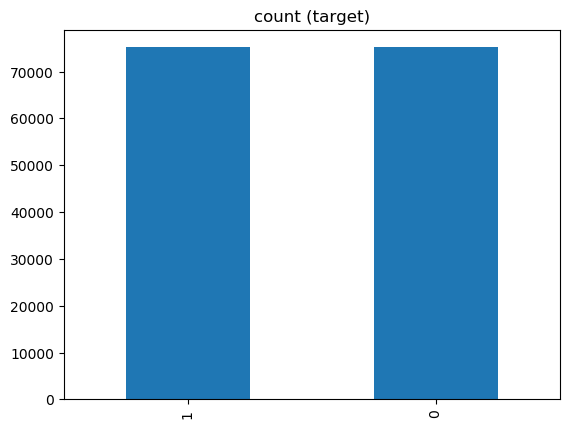

In [73]:
print("total class of 1 and 0:",test_oversamp['is_canceled'].value_counts())
test_oversamp['is_canceled'].value_counts().plot(kind='bar', title='count (target)')

In [74]:
test_oversamp['is_canceled'].value_counts()

1    75166
0    75166
Name: is_canceled, dtype: int64

#### dimension reduction

In [75]:
test_oversamp.var()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


hotel                                 0.216917
is_canceled                           0.250002
lead_time                         12251.671898
arrival_date_year                     0.501851
arrival_date_month                    9.410713
arrival_date_day_of_month            76.901774
stays_in_weekend_nights               1.005993
stays_in_week_nights                  3.656563
adults                                0.295610
children                              0.161040
babies                                0.008568
is_repeated_guest                     0.027082
previous_cancellations                0.953392
previous_bookings_not_canceled        1.805771
booking_changes                       0.377587
agent                             11021.371924
days_in_waiting_list                348.444292
adr                                   0.000097
required_car_parking_spaces           0.048423
total_of_special_requests             0.595657
reservation_year                      0.515463
reservation_m

#### No need for dimensionality reduction as all numeric values that are continous have already been dealt with previously. 

#### Groupby to ready data for modeling

In [76]:
test_oversamp = test_oversamp.rename(columns={"reservation_status_date": "date"})

In [77]:
bookings_grouped = test_oversamp.groupby(['date']).count()
bookings_grouped.head()


# bookings_grouped = test_oversamp.groupby('reservation_status_date', sort=False)['reservation_year'].count()
# #




,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_year,reservation_month,reservation_day,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-17,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318
2014-11-18,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2015-01-01,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285
2015-01-02,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
2015-01-18,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [78]:
bookings_grouped['total_bookings'] = test_oversamp.groupby('date', sort=False)['reservation_year'].count()
bookings_grouped['total_bookings'].head()


date
2014-10-17     318
2014-11-18       1
2015-01-01    1285
2015-01-02      16
2015-01-18       1
Name: total_bookings, dtype: int64

In [79]:
bookings_grouped.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_year,reservation_month,reservation_day,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,total_bookings
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-17,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318
2014-11-18,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2015-01-01,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285
2015-01-02,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
2015-01-18,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [80]:
bookings_grouped['cancellations'] = bookings_grouped.groupby('date', sort=False)['is_canceled'].sum()
bookings_grouped['cancellations'].head

<bound method NDFrame.head of date
2014-10-17     318
2014-11-18       1
2015-01-01    1285
2015-01-02      16
2015-01-18       1
2015-01-20       6
2015-01-21     146
2015-01-22       7
2015-01-28       3
2015-01-30     113
2015-02-02       1
2015-02-05       6
2015-02-06       1
2015-02-09       1
2015-02-10       3
2015-02-11       5
2015-02-12       1
2015-02-17       3
2015-02-19       2
2015-02-20      30
2015-02-23       3
2015-02-24       1
2015-02-25       4
2015-02-26       1
2015-02-27       2
2015-03-03      61
2015-03-04       5
2015-03-05       2
2015-03-06       3
2015-03-09       6
2015-03-10       2
2015-03-12       3
2015-03-13       2
2015-03-17       4
2015-03-18       3
2015-03-23       5
2015-03-24       6
2015-03-25      31
2015-03-28       1
2015-03-29       4
2015-03-30       4
2015-03-31      10
2015-04-02      25
2015-04-03       3
2015-04-04      10
2015-04-05       8
2015-04-06       5
2015-04-07       1
2015-04-08       4
2015-04-10       7
2015-04-11     

In [81]:
bookings_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 922 entries, 2014-10-17 to 2017-09-14
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   hotel                           922 non-null    int64
 1   is_canceled                     922 non-null    int64
 2   lead_time                       922 non-null    int64
 3   arrival_date_year               922 non-null    int64
 4   arrival_date_month              922 non-null    int64
 5   arrival_date_day_of_month       922 non-null    int64
 6   stays_in_weekend_nights         922 non-null    int64
 7   stays_in_week_nights            922 non-null    int64
 8   adults                          922 non-null    int64
 9   children                        922 non-null    int64
 10  babies                          922 non-null    int64
 11  is_repeated_guest               922 non-null    int64
 12  previous_cancellations          922 non-null 

In [82]:
bookings_grouped.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_year,reservation_month,reservation_day,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,total_bookings,cancellations
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-17,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,...,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318
2014-11-18,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2015-01-01,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,...,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285,1285
2015-01-02,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
2015-01-18,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [83]:
# bookings_grouped_cancellations['cancellations'] = test_oversamp.groupby('reservation_year', sort=False)['is_canceled'].count()
# bookings_grouped_cancellations['cancellations'].head()

#### Visualize data

In [84]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=bookings_grouped, x ='date', y = 'total_bookings', palette='viridis', lw=3)
plt.title("Total Bookings by Month/Year")
plt.show()

ValueError: Could not interpret input 'date'

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=bookings_grouped, x ='date', y = 'cancellations', palette='viridis', lw=3)
plt.title("Total Cancellations by Month/Year")
plt.show()

In [ ]:
income['date'] = income['date'].apply(lambda x: str(x))

In [85]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [86]:
income_grouped = income.groupby('date').sum()
income_grouped.head()

KeyError: 'date'

In [87]:
income_grouped['Value_year'] = income.groupby('date', sort=False)['year'].sum()
income_grouped.head()

KeyError: 'date'

In [88]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=income_grouped, x ='date', y = 'Value_year', palette='viridis', lw=3)
plt.title("Total Income by Month/Year")
plt.show()

NameError: name 'income_grouped' is not defined

##### Store Data frames

In [89]:
%store income_grouped

UsageError: Unknown variable 'income_grouped'


In [90]:
%store bookings_grouped

Stored 'bookings_grouped' (DataFrame)


#### Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}